In [1]:
from datasets import load_dataset
mnist=load_dataset("mnist")
mnist

c:\Users\Hammad\anaconda3\envs\Hammad\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

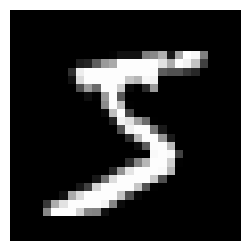

In [2]:
from genaibook.core import show_images
import matplotlib as mpl

mpl.rcParams["image.cmap"]="gray"
show_images(mnist["train"]["image"][:1])



In [3]:
from torchvision import transforms
def mnist_to_tensor(sampels):
    t=transforms.ToTensor() 
    sampels["image"]=[t(s) for s in sampels["image"]]
    return sampels

In [4]:
mnist=mnist.with_transform(mnist_to_tensor)
mnist["train"]=mnist["train"].shuffle(seed=1337)

In [5]:
x=mnist["train"]["image"][0]
x.min(),x.max()

(tensor(0.), tensor(1.))

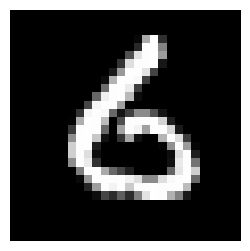

In [6]:
show_images(mnist["train"]["image"][0])

In [7]:
from torch.utils.data import DataLoader

bs=64
train_data_loader=DataLoader(mnist["train"]["image"],batch_size=bs,shuffle=True)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU()
    )

In [9]:
class Encoder(nn.Module):
    def __init__(self,in_channels):
        super().__init__()
        self.conv1=conv_block(in_channels,128)
        self.conv2=conv_block(128,256)
        self.conv3=conv_block(256,512)
        self.conv4=conv_block(512,1024)
        self.linear=nn.Linear(1024,16)
    
    def forward(self,x):
        x=self.conv1(x) # (batch_size,128,14,14)
        x=self.conv2(x) # (batch_size,256,7,7)
        x=self.conv3(x) # (batch_size,512,3,3)
        x=self.conv4(x) # (batch_size,1024,1,1)
        x=torch.flatten(x,start_dim=1) # (batch_size)
        x=self.linear(x) # (batch_size,16)
        return x
    

In [10]:
in_channels=1
encoder=Encoder(in_channels).eval()
x=mnist["train"]["image"][0].unsqueeze(0)
print(x.shape)
encoded=encoder(x)



torch.Size([1, 1, 28, 28])


In [11]:
encoded

tensor([[ 0.0195,  0.0335,  0.0160, -0.0051,  0.0078,  0.0046, -0.0247, -0.0180,
          0.0146, -0.0145,  0.0012,  0.0335,  0.0044, -0.0127,  0.0188, -0.0136]],
       grad_fn=<AddmmBackward0>)

In [12]:
batch=next(iter(train_data_loader))
batch.shape

torch.Size([64, 1, 28, 28])

In [13]:
encoded=Encoder(in_channels)(batch)
encoded.shape

torch.Size([64, 16])

In [14]:
def conv_transpose_block(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=0, with_act=True):
    layers = [
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding),
        
    ]
    if with_act:
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [15]:
class Decoder(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.linear = nn.Linear(16, 1024 * 4 * 4)
        self.conv_transpose1 = conv_transpose_block(1024, 512)
        self.conv_transpose2 = conv_transpose_block(512, 256,output_padding=1)
        self.conv_transpose3 = conv_transpose_block(256,out_channels,output_padding=1)
  
    
    def forward(self, x):
        bs=x.shape[0]
        x = self.linear(x)
        x = x.reshape((bs, 1024, 4, 4))
        x = self.conv_transpose1(x)
        x = self.conv_transpose2(x)
        x = self.conv_transpose3(x)
        return x
    
decoded_batch=Decoder(x.shape[0])(encoded)
decoded_batch.shape

torch.Size([64, 1, 28, 28])

In [16]:
class AutoEncoder(nn.Module):
    def __init__(self,in_channels):
        super().__init__()
        self.encoder=Encoder(in_channels)
        self.decoder=Decoder(in_channels)
    
    def encode(self,x):
        return self.encoder(x)
    def decode(self,z):
        return self.decoder(z)
    def forward(self,x):
        z=self.encode(x)
        x_hat=self.decode(z)
        return x_hat

model=AutoEncoder(1)

In [17]:
import torchsummary
torchsummary.summary(model,(1,28,28),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                   [-1, 16]          16,400
          Encoder-14                   

In [18]:
import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from tqdm.auto import tqdm, trange
from genaibook.core import get_device

num_epochs=20
lr=1e-4
device=get_device()
model=model.to(device)
optimizer=torch.optim.AdamW(model.parameters(),lr=lr,eps=1e-5)
losses=[]
for _ in (progress := trange(num_epochs, desc="Training")):
    for _,batch in ( inner := tqdm(enumerate(train_data_loader), total=len(train_data_loader))):
        batch=batch.to(device)
        
        x_hat=model(batch)
        loss=F.mse_loss(x_hat,batch)

        # Display loss and store for plotting
        inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
        

Training: 100%|██████████| 20/20 [05:46<00:00, 17.35s/it, loss=0.006, lr=1e-04]


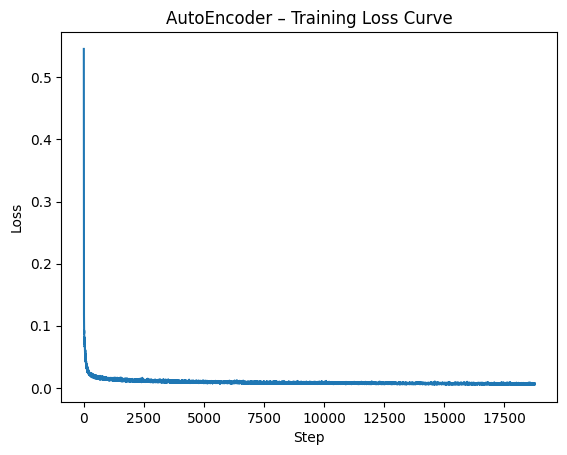

In [19]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("AutoEncoder – Training Loss Curve")
plt.show()

In [20]:
eval_bs=16
eval_data_loader=DataLoader(mnist["test"]["image"],batch_size=eval_bs,shuffle=True)
model=model.eval()
with torch.inference_mode():
    eval_batch=next(iter(eval_data_loader))
    predicted=model(eval_batch.to(device)).cpu()



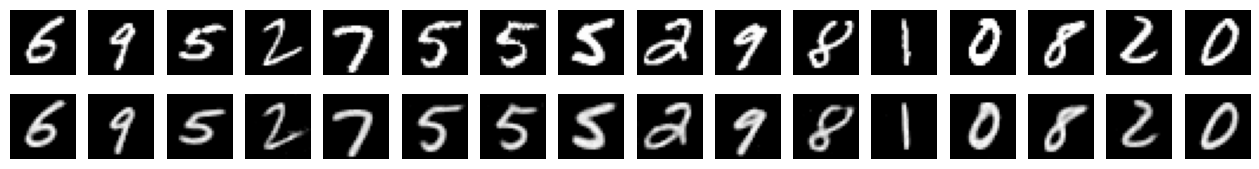

In [21]:
batch_vs_pred=torch.cat((eval_batch,predicted))
show_images(batch_vs_pred,imsize=1,nrows=2)



Latent Space Visualization

In [ ]:
class Encoder(nn.Module):
    def __init__(self,in_channels,latent_dim):
        super().__init__()
        self.conv_layers=nn.Sequential(
            conv_block(in_channels,128),
            conv_block(128,256),
            conv_block(256,512),
            conv_block(512,1024)
        )   
        self.linear=nn.Linear(1024,latent_dim)
    
    def forward(self,x):
        bs=x.shape[0]
        x=self.conv_layers(x) # (batch_size,1024,1,1)
        x=self.linear(x.reshape(bs,-1)) # (batch_size,latent_dim)
        return x


class Decoder(nn.Module):
    def __init__(self,in_channels,latent_dim):
        super().__init__()
        self.linear=nn.Linear(latent_dim,1024*4*4)
        self.conv_transpose_layers=nn.Sequential(
            conv_transpose_block(1024,512),
            conv_transpose_block(512,256,output_padding=1),
            conv_transpose_block(256,in_channels,output_padding=1,with_act=False),
        )
        self.sigmoid=nn.Sigmoid()
        
    def forward(self,z):
        bs=z.shape[0]
        x=self.linear(z)
        x=x.reshape(bs,1024,4,4)
        x=self.conv_transpose_layers(x)
        x=self.sigmoid(x)
        return x


class AutoEncoder(nn.Module):  
    def __init__(self,in_channels,latent_dim):
        super().__init__()
        self.encoder=Encoder(in_channels,latent_dim)
        self.decoder=Decoder(in_channels,latent_dim)
    def encode(self,x):
        return self.encoder(x)
    def decode(self,z):
        return self.decoder(z)
    def forward(self,x):
        z=self.encode(x)
        x_hat=self.decode(z)
        return x_hat

In [23]:
def train(model,train_data_loader,num_epochs=20,lr=1e-4):
    losses=[]
    device=get_device()
    model=model.to(device)
    model.train()
    optimizer=torch.optim.AdamW(model.parameters(),lr=lr,eps=1e-5)
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _,batch in ( inner := tqdm(enumerate(train_data_loader), total=len(train_data_loader))):
            batch=batch.to(device)
            x_hat=model(batch)
            loss=F.mse_loss(x_hat,batch)
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
    return losses

In [24]:
ae_model=AutoEncoder(1,2)
ae_model.to(device)
losses=train(ae_model,train_data_loader)

Training: 100%|██████████| 20/20 [05:07<00:00, 15.37s/it, loss=0.038, lr=1e-04]


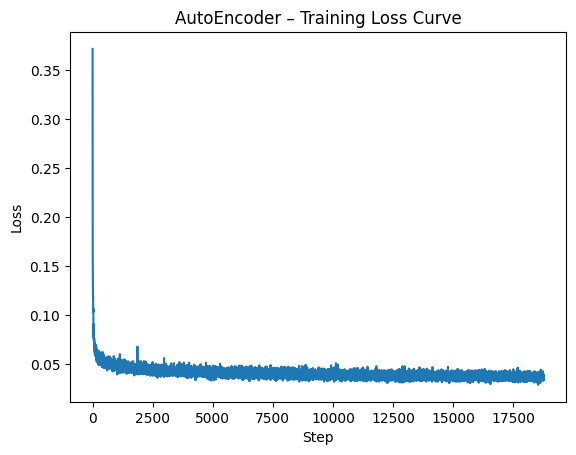

In [25]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("AutoEncoder – Training Loss Curve")
plt.show()

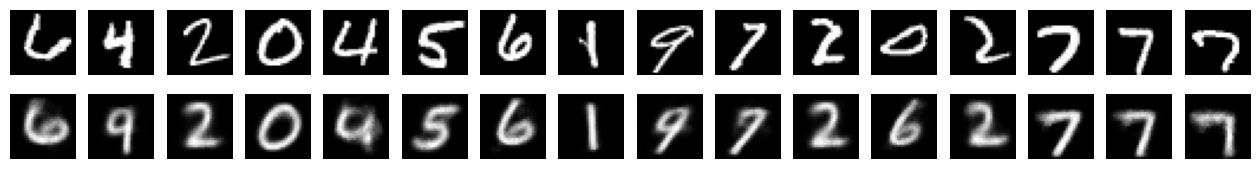

In [26]:
ae_model.eval()
with torch.inference_mode():
    eval_batch=next(iter(eval_data_loader))
    predicted=ae_model(eval_batch.to(device)).cpu()

batch_vs_pred=torch.cat((eval_batch,predicted))
show_images(batch_vs_pred,imsize=1,nrows=2)

Visualizing the Latent Space

100%|██████████| 20/20 [00:01<00:00, 19.17it/s]


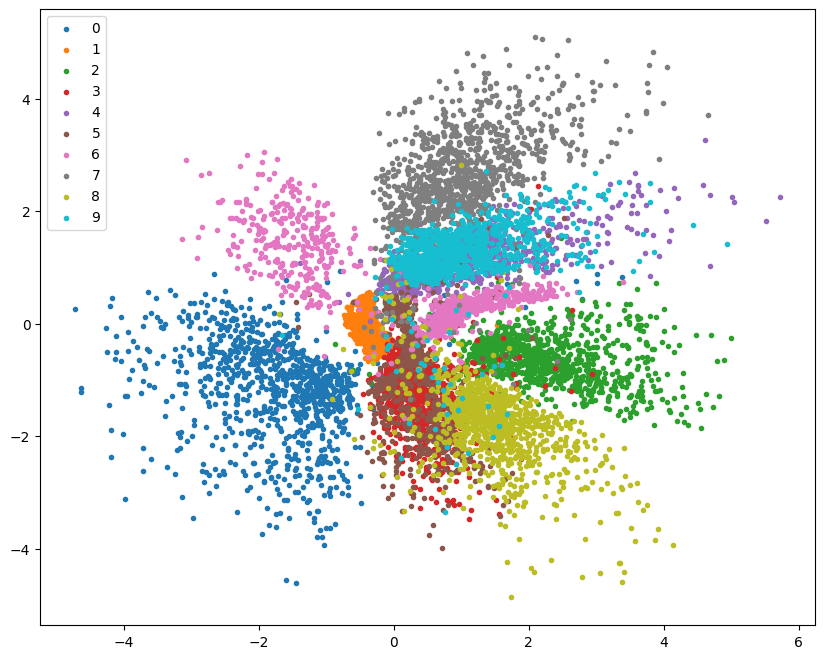

In [28]:
images_labels_dataloader=DataLoader(mnist["test"],batch_size=512)
import pandas as pd
df=pd.DataFrame(
    {
        "x": [],
        "y": [],
        "label": [],
    }
)

for batch in tqdm(iter(images_labels_dataloader),total=len(images_labels_dataloader)):
    encoded=ae_model.encode(batch["image"].to(device)).cpu()
    new_items={
        "x": [t.item() for t in encoded[:,0]],
        "y": [t.item() for t in encoded[:,1]],
        "label": batch["label"],
    }
    df=pd.concat([df,pd.DataFrame(new_items)],ignore_index=True)

plt.figure(figsize=(10,8))
for label in range(10):
    points=df[df["label"]==label]
    plt.scatter(points["x"],points["y"],label=label,marker=".")
plt.legend()


In [33]:
N=16
z=torch.rand((N,2))*8-4

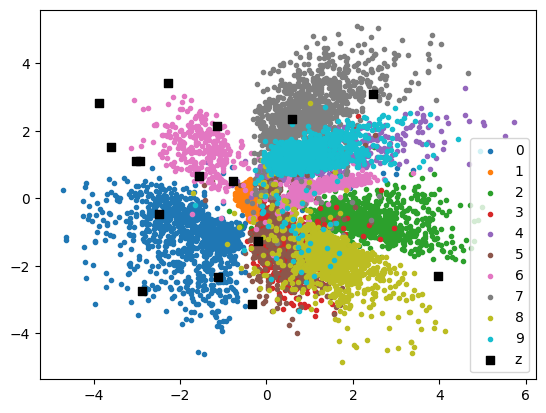

In [34]:
plt.Figure(figsize=(10,8))
for label in range(10):
    points=df[df["label"]==label]
    plt.scatter(points["x"],points["y"],label=label,marker=".")
plt.scatter(z[:,0],z[:,1],label="z",marker="s",color="black")
plt.legend()

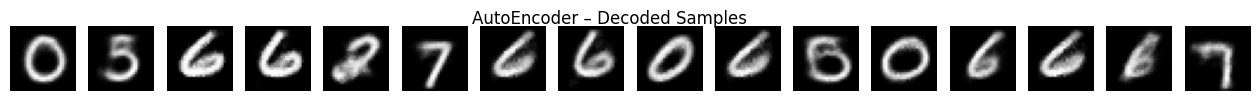

In [35]:
ae_decoded=ae_model.decode(z.to(device))
show_images(ae_decoded,imsize=1,nrows=1,suptitle="AutoEncoder – Decoded Samples")    

Classification Problem

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
from genaibook.core import show_images
import matplotlib as mpl
from torchsummary import summary
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


c:\Users\Hammad\anaconda3\envs\Hammad\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU()
    )

def conv_transpose_block(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=0, with_act=True):
    layers = [
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding),
        
    ]
    if with_act:
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

class Encoder(nn.Module):
    def __init__(self,in_channels,latent_dim):
        super().__init__()
        self.conv_layers=nn.Sequential(
            conv_block(in_channels,128),
            conv_block(128,256),
            conv_block(256,512),
            conv_block(512,1024)
        )   
        self.linear=nn.Linear(1024,latent_dim)
    
    def forward(self,x):
        bs=x.shape[0]
        x=self.conv_layers(x)
        x=self.linear(x.reshape(bs,-1))
        return x

class Decoder(nn.Module):
    def __init__(self,in_channels,latent_dim):
        super().__init__()
        self.linear=nn.Linear(latent_dim,1024*4*4)
        self.conv_transpose_layers=nn.Sequential(
            conv_transpose_block(1024,512),
            conv_transpose_block(512,256,output_padding=1),
            conv_transpose_block(256,in_channels,output_padding=1,with_act=False),
        )
        self.sigmoid=nn.Sigmoid()
        
    def forward(self,z):
        bs=z.shape[0]
        x=self.linear(z)
        x=x.reshape(bs,1024,4,4)
        x=self.conv_transpose_layers(x)
        x=self.sigmoid(x)
        return x

class AutoEncoder(nn.Module):  
    def __init__(self,in_channels,latent_dim):
        super().__init__()
        self.encoder=Encoder(in_channels,latent_dim)
        self.decoder=Decoder(in_channels,latent_dim)
    def encode(self,x):
        return self.encoder(x)
    def decode(self,z):
        return self.decoder(z)
    def forward(self,x):
        z=self.encode(x)
        x_hat=self.decode(z)
        return x_hat
    
def train(model,train_data_loader,num_epochs=20,lr=1e-4):
    losses=[]
    device=get_device()
    model=model.to(device)
    model.train()
    optimizer=torch.optim.AdamW(model.parameters(),lr=lr,eps=1e-5)
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _,batch in ( inner := tqdm(enumerate(train_data_loader), total=len(train_data_loader))):
            batch=batch.to(device)
            x_hat=model(batch)
           

            loss=F.mse_loss(x_hat,batch)

            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses.append(loss.item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
    return losses

In [3]:
from datasets import load_dataset
mnist=load_dataset("mnist")


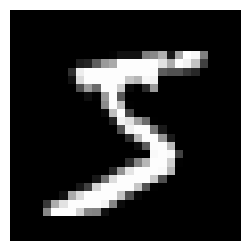

In [4]:
mpl.rcParams["image.cmap"]="gray"
show_images(mnist["train"]["image"][:1])

In [5]:
def mnist_to_tensor(sampels):
    t=transforms.ToTensor() 
    sampels["image"]=[t(s) for s in sampels["image"]]
    return sampels

mnist=mnist.with_transform(mnist_to_tensor)
mnist["train"]=mnist["train"].shuffle(seed=1337)
train_data_loader=DataLoader(mnist["train"]["image"],batch_size=64,shuffle=True)

In [6]:
in_channels=1
latent_dim=64
encoder=Encoder(in_channels,latent_dim).eval()
x=mnist["train"]["image"][0].unsqueeze(0)
print(x.shape)
encoded=encoder(x)
encoded


torch.Size([1, 1, 28, 28])


tensor([[ 0.0159,  0.0269,  0.0247, -0.0343,  0.0254, -0.0139,  0.0126,  0.0105,
         -0.0213, -0.0019, -0.0004, -0.0212, -0.0278,  0.0146, -0.0056,  0.0043,
          0.0036, -0.0173, -0.0051,  0.0218, -0.0177,  0.0150,  0.0038,  0.0085,
          0.0218, -0.0127,  0.0287, -0.0089, -0.0298,  0.0189,  0.0318, -0.0162,
          0.0093,  0.0330, -0.0120, -0.0052,  0.0202, -0.0161,  0.0004, -0.0051,
          0.0036, -0.0074,  0.0230,  0.0017, -0.0103,  0.0035, -0.0231, -0.0328,
          0.0018,  0.0227,  0.0245, -0.0009,  0.0058,  0.0094, -0.0240, -0.0007,
          0.0248,  0.0310, -0.0261,  0.0260,  0.0179, -0.0065, -0.0025, -0.0133]],
       grad_fn=<AddmmBackward0>)

In [7]:
model=AutoEncoder(in_channels,latent_dim)
summary(model,(1,28,28),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                   [-1, 64]          65,600
          Encoder-14                   

In [8]:
from genaibook.core import get_device
device=get_device()
device

device(type='cuda')

In [9]:
losses=train(model,train_data_loader)

Training: 100%|██████████| 20/20 [05:12<00:00, 15.65s/it, loss=0.002, lr=1e-04]


In [10]:
#classifications over Encoder output

class classifier(nn.Module):
    def __init__(self,latent_dim):
        super().__init__()
        self.linear=nn.Linear(latent_dim,1024)
        self.linear2=nn.Linear(1024,512)
        self.linear3=nn.Linear(512,10)
        self.softmax=nn.Softmax(dim=1)
    def forward(self,z):
        x=self.linear(z)
        x=self.linear2(x)
        x=self.linear3(x)
        x=self.softmax(x)
        return x
model_classifier=classifier(latent_dim)
model_classifier=model_classifier.to(device)

In [12]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def encode_data(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    encoded_data = []
    labels = []

    with torch.no_grad():  # No need to compute gradients
        for batch in tqdm(data_loader, desc="Encoding Data"):
            images = batch["image"].to(device).float() / 255.0  # Normalize images
            encoded = model.encode(images)  # Pass through encoder
            encoded_data.append(encoded.cpu())  # Move to CPU for storage
            labels.append(batch["label"])  # Store labels
    
    # Convert to tensors
    encoded_data = torch.cat(encoded_data, dim=0)
    labels = torch.cat(labels, dim=0)

    return encoded_data, labels

# Load MNIST train data
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(mnist["train"], batch_size=batch_size, shuffle=False)

# Encode the dataset
encoded_features, labels = encode_data(model, train_loader, device)

print(encoded_features.shape, labels.shape)


Encoding Data: 100%|██████████| 469/469 [00:07<00:00, 64.52it/s]

torch.Size([60000, 64]) torch.Size([60000])


In [13]:
train_data_loader=DataLoader(TensorDataset(encoded_features,labels),batch_size=64,shuffle=True)
print(train_data_loader.dataset.tensors[0].shape,train_data_loader.dataset.tensors[1].shape)    

torch.Size([60000, 64]) torch.Size([60000])


In [14]:
def train_classifier(model,train_data_loader,num_epochs=20,lr=1e-4):
    losses=[]
    device=get_device()
    model=model.to(device)
    model.train()
    optimizer=torch.optim.AdamW(model.parameters(),lr=lr,eps=1e-5)
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _,batch in ( inner := tqdm(enumerate(train_data_loader), total=len(train_data_loader))):
            batch[0]=batch[0].to(device)
            batch[1]=batch[1].to(device)
            x_hat=model(batch[0])
            loss=F.cross_entropy(x_hat,batch[1])
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
    return losses

In [15]:
losses=train_classifier(model_classifier,train_data_loader)

Training: 100%|██████████| 20/20 [01:01<00:00,  3.10s/it, loss=1.645, lr=1e-04]


In [ ]:
def encode_data(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    encoded_data = []
    labels = []

    with torch.no_grad():  # No need to compute gradients
        for batch in tqdm(data_loader, desc="Encoding Data"):
            images = batch["image"].to(device).float() / 255.0  # Normalize images
            encoded = model.encode(images)  # Pass through encoder
            encoded_data.append(encoded.cpu())  # Move to CPU for storage
            labels.append(batch["label"])  # Store labels
    
    # Convert to tensors
    encoded_data = torch.cat(encoded_data, dim=0)
    labels = torch.cat(labels, dim=0)

    return encoded_data, labels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [20]:
from tqdm import tqdm
import torch

def eval_classifier(model, model_2,data_loader, device):
    model_2.eval()
    model.eval()  # Set model to evaluation mode
    correct, total = 0, 0

    with torch.no_grad():  # No need to compute gradients
        for batch in tqdm(data_loader, desc="Evaluating"):
            images = batch["image"].to(device).float() / 255.0  # Extract images and normalize
            labels = batch["label"].to(device)  # Extract labels
            encoded = model_2.encode(images)
            outputs = model(encoded)  # Get model predictions
            _, predicted = torch.max(outputs, 1)  # Get predicted class

            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Count correct predictions

    accuracy = correct / total
    return accuracy

# Load MNIST test data
batch_size = 128
test_loader = DataLoader(mnist["test"], batch_size=batch_size, shuffle=False)

# Run classifier evaluation
accuracy = eval_classifier(model_classifier,model,test_loader, device)
print(f"Classifier Accuracy: {accuracy:.4f}")


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 56.16it/s]

Classifier Accuracy: 0.8713
